<a href="https://colab.research.google.com/github/MaryGloria23/LLM-TCRpMHC-MODELS/blob/main/Copy_of_LSTM_MODEL_FOR_TCR_pMHC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the grammar of T-cell antigen recognition using fine-tuned large language models

## 1: Grammar of T-cell antigen **recognition**

# 2: Modeling TCR-peptide-MHC interactions

In [1]:
# @title 2.1: Install Dependencies
# Use -q to make the installation less verbose
!pip install -q torch transformers datasets tokenizers sentencepiece pandas
              #-q: Makes the output less verbose (quiet mode)
              #torch: PyTorch, a deep learning framework.
              #transformers: Hugging Face's library for pre-trained NLP models.
              #datasets: Hugging Face's dataset library for loading and processing datasets.
              #tokenizers: Fast tokenization library used with transformers.
              #sentencepiece: Tokenizer used for models like T5 and BERT.
              #pandas: Data manipulation and analysis library.

# For the LSTM model with TensorFlow
!pip install -q tensorflow
              #Installs TensorFlow, another popular deep learning framework.
              #Useful if you're building or training LSTM (Long Short-Term Memory) models.

!wget https://github.com/antigenomics/vdjdb-db/releases/download/pyvdjdb-2025-02-21/vdjdb-2025-02-21.zip
!unzip vdjdb-2025-02-21.zip

--2025-09-25 03:21:45--  https://github.com/antigenomics/vdjdb-db/releases/download/pyvdjdb-2025-02-21/vdjdb-2025-02-21.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/49149680/fd240948-34d6-49ef-99da-4035aedf4cd8?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-25T04%3A09%3A34Z&rscd=attachment%3B+filename%3Dvdjdb-2025-02-21.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-25T03%3A08%3A43Z&ske=2025-09-25T04%3A09%3A34Z&sks=b&skv=2018-11-09&sig=GmwoWjCQe6tOFvljK%2FlohgOQc3tGHGWvN8XOWTZfqX0%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODc3MDcyOCwibmJmIjoxNzU4NzcwNDI4LCJwYXRoIjoicmVsZ

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# @title 2.2: Download and Prepare the VDJdb Dataset (Corrected)
import pandas as pd
import requests
import zipfile
import io
import os

vdj_db = "vdjdb-2025-02-21/vdjdb.slim.txt"
# Load the data into a pandas DataFrame
df = pd.read_csv(vdj_db, sep='\t')

# We are interested in the amino acid sequence of the CDR3 region
# Let's filter for human TRB (T-cell Receptor Beta) chains for consistency
df_human_trb = df[(df['gene'] == 'TRB') & (df['species'] == 'HomoSapiens')]

sequences = df_human_trb['cdr3'].tolist()[:50] #Extracts the CDR3 region. Converts the column to a list and selects the first 50 sequences.
sequences

large_sequence = df_human_trb['cdr3'].tolist()[:5000] #Extracts the first 5000 CDR3 sequences for more extensive analysis or model training


test = df_human_trb['cdr3'].tolist()[-50:] #Extracts the last 50 sequences from the filtered dataset. Useful for testing or validation purposes.

In [4]:
df_selected = df_human_trb[['cdr3', 'antigen.epitope', 'mhc.a']]

In [5]:
!wget ftp://ftp.ebi.ac.uk:21/pub/databases/ipd/imgt/hla/hla_prot.fasta

--2025-09-25 03:21:47--  ftp://ftp.ebi.ac.uk/pub/databases/ipd/imgt/hla/hla_prot.fasta
           => ‘hla_prot.fasta’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/ipd/imgt/hla ... done.
==> SIZE hla_prot.fasta ... 13472583
==> PASV ... done.    ==> RETR hla_prot.fasta ... done.
Length: 13472583 (13M) (unauthoritative)

hla_prot.fasta      100%[===================>]  12.85M  7.46MB/s    in 1.7s    

2025-09-25 03:21:51 (7.46 MB/s) - ‘hla_prot.fasta’ saved [13472583]



In [6]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 102.5 MB/s eta 0:00:00


In [7]:
from Bio import SeqIO

# Create a dictionary: allele (e.g., A*01:01) → protein sequence
hla_dict = {}

for record in SeqIO.parse("hla_prot.fasta", "fasta"):
    header = record.description
    sequence = str(record.seq)

    # Extract allele name from header (e.g., A*01:01:01:01 → A*01:01)
    parts = header.split()
    full_allele = parts[1]  # e.g., A*01:01:01:01
    short_allele = ":".join(full_allele.split(":")[:2])  # e.g., A*01:01

    hla_dict[short_allele] = sequence
# Replace mhc.a with the corresponding protein sequence
#df_selected['mhc.a_protein'] = df_selected['mhc.a'].map(hla_dict)
df_selected['mhc.a_protein'] = df_selected['mhc.a'].str.replace("HLA-", "").map(hla_dict)

#df_selected = df_selected.drop(columns=['mhc.a'])


/tmp/ipython-input-2882553325.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['mhc.a_protein'] = df_selected['mhc.a'].str.replace("HLA-", "").map(hla_dict)


In [8]:
from Bio import SeqIO

target_allele = "DRA*01:01:01"

for record in SeqIO.parse("hla_prot.fasta", "fasta"):
    header = record.description
    sequence = str(record.seq)

    # Extract allele from header
    parts = header.split()
    full_allele = parts[1]  # e.g., A*02:01:01:01
    short_allele = ":".join(full_allele.split(":")[:2])  # → A*02:01

    if short_allele == target_allele:
        print(f"Found: {short_allele}")
        print(f"Header: {header}")
        print(f"Sequence (first 60 aa): {sequence[:60]}")
        break
else:
    print(f"{target_allele} not found in FASTA file.")


DRA*01:01:01 not found in FASTA file.


In [9]:
df_selected = df_selected.drop(columns=['mhc.a'])

In [10]:
df_clean = df_selected.dropna(subset=['mhc.a_protein'])

In [11]:
from sklearn.model_selection import train_test_split

# Step 2: Split into 80% train and 20% temp (val + test)
df_train, df_temp = train_test_split(df_clean, test_size=0.2, random_state=42)

# Step 3: Split temp into 10% val and 10% test
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")


Train size: 28140
Validation size: 3517
Test size: 3518


In [12]:
def concatenate_sequences(row):
    return row['cdr3'] + '|' + row['antigen.epitope'] + '|' + row['mhc.a_protein']

df_train['input_seq'] = df_train.apply(concatenate_sequences, axis=1)
df_val['input_seq'] = df_val.apply(concatenate_sequences, axis=1)
df_test['input_seq'] = df_test.apply(concatenate_sequences, axis=1)

TRIAL: SPLIT THE INPUT

In [13]:
import pandas as pd

# Function to truncate MHC to first 50 chars
def make_input_seq(row):
    cdr3 = row['cdr3']
    epitope = row['antigen.epitope']
    mhc120 = row['mhc.a_protein'][:120]  # first 120 characters
    return f"{cdr3}|{epitope}|{mhc120}"

# Create a new column with truncated sequences
df_train['input_seq_subset'] = df_train.apply(make_input_seq, axis=1)

# Optional: create a smaller df with only the relevant column
df_subset = df_train[['cdr3', 'antigen.epitope', 'mhc.a_protein', 'input_seq_subset']].copy()

# Inspect
print(df_subset.head())

                   cdr3 antigen.epitope  \
65610   CASSQGGQGKGGYTF       KLGGALQAK   
59156  CASSNYRPFSTDTQYF       GILGFVFTL   
83321    CSGVLAPSYNEQFF       KLGGALQAK   
51294     CASSLDWGNTIYF       KLGGALQAK   
45294     CASSFRAGNEQFF       GILGFVFTL   

                                           mhc.a_protein  \
65610  MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   
59156  MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   
83321  MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   
51294  MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   
45294  MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   

                                        input_seq_subset  
65610  CASSQGGQGKGGYTF|KLGGALQAK|MAVMAPRTLLLLLSGALALT...  
59156  CASSNYRPFSTDTQYF|GILGFVFTL|MAVMAPRTLVLLLSGALAL...  
83321  CSGVLAPSYNEQFF|KLGGALQAK|MAVMAPRTLLLLLSGALALTQ...  
51294  CASSLDWGNTIYF|KLGGALQAK|MAVMAPRTLLLLLSGALALTQT...  
45294  CASSFRAGNEQFF|GILGFVFTL|MAVMAPRTLVLLLSGALALTQT...  


TOKENIZATION (CHARACTER LEVEL)
This section usually involves:
Encoding amino acid characters into integers using a vocabulary dictionary.
Padding sequences to a fixed length for batch processing.



In [14]:
# Create the character set from your new subset sequences
all_chars = sorted(list(set("".join(df_subset['input_seq_subset']))))  # use subset column
PAD_TOKEN = "<PAD>"
all_chars.append(PAD_TOKEN)
'''Padding
        Sequences (like your TCR, epitope, and MHC strings) can have different lengths.
        But neural networks (like LSTMs) expect fixed-length inputs in a batch.
        Padding means adding a special “dummy” token (e.g. <PAD>) to make all sequences the same length.

        Example:
        CATRDGLSDEQFF   → CATRDGLSDEQFF <PAD> <PAD> ...
        CASSYGT         → CASSYGT <PAD> <PAD> <PAD> ...
        The <PAD> token is ignored in loss calculation so it doesn’t affect training.
        Think of it like filling empty seats in a row with placeholders so all rows are equal length.
'''

# Create mappings
char_to_int = {char: i for i, char in enumerate(all_chars)}
int_to_char = {i: char for char, i in char_to_int.items()}
PAD_IDX = char_to_int[PAD_TOKEN]
vocab_size = len(all_chars)

# Pick a sample input sequence
sample_seq = df_subset['input_seq_subset'].iloc[0]
print("Original sequence:", sample_seq)

# Encode the sequence
encoded_seq = [char_to_int[c] for c in sample_seq]
print("Encoded sequence:", encoded_seq)

# Decode it back
decoded_seq = "".join([int_to_char[i] for i in encoded_seq])
print("Decoded sequence:", decoded_seq)

# Check if original and decoded match
print("Match:", sample_seq == decoded_seq)


Original sequence: CASSQGGQGKGGYTF|KLGGALQAK|MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQ
Encoded sequence: [1, 0, 15, 15, 13, 5, 5, 13, 5, 8, 5, 5, 19, 16, 4, 20, 8, 9, 5, 5, 0, 9, 13, 0, 8, 20, 10, 0, 17, 10, 0, 12, 14, 16, 9, 9, 9, 9, 9, 15, 5, 0, 9, 0, 9, 16, 13, 16, 18, 0, 5, 15, 6, 15, 10, 14, 19, 4, 4, 16, 15, 17, 15, 14, 12, 5, 14, 5, 3, 12, 14, 4, 7, 0, 17, 5, 19, 17, 2, 2, 16, 13, 4, 17, 14, 4, 2, 15, 2, 0, 0, 15, 13, 14, 10, 3, 12, 14, 0, 12, 18, 7, 3, 13, 3, 5, 12, 3, 19, 18, 2, 13, 3, 16, 14, 11, 17, 8, 0, 13, 15, 13, 16, 2, 14, 17, 2, 9, 5, 16, 9, 14, 5, 19, 19, 11, 13, 15, 3, 0, 5, 15, 6, 16, 7, 13]
Decoded sequence: CASSQGGQGKGGYTF|KLGGALQAK|MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQ
Match: True


In [15]:
'''
After making the vocab, here we take each sequence in the training set and:
For each position in the sequence, creates a prefix (from start to position i) as input, and the character at position i as target.
This is the typical “next-token prediction / language modeling” framing.
Then it pads each input prefix to the maximum sequence length (or maximum among training), using PAD_IDX, so all inputs are the same length for batch training.
Converts them to PyTorch tensors and builds a DataLoader (or TensorDataset) for batching.
This chunk essentially prepares (X, y) pairs for training.
'''

import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Step 1: Collect sequences from your new subset ---
sequences = df_subset['input_seq_subset'].tolist()

# --- Step 2: Create input-output pairs ---
X, y = [], []
max_len = max(len(s) for s in sequences)

for sc, seq in enumerate(sequences):
    if sc == 0:
        print(f"Original sequence: {seq}")
    for i in range(1, len(seq)):
        input_seq = seq[:i]
        output_char = seq[i]
        X.append([char_to_int[c] for c in input_seq])
        y.append(char_to_int[output_char])
        if sc == 0 and i < 20:  # print a few examples
            print(f"Input: {input_seq} --> Output: {output_char}")

# --- Step 3: Pad inputs to fixed length ---
padded_X = np.array([
    np.pad(x, (max_len - 1 - len(x), 0), 'constant', constant_values=PAD_IDX)
   for x in X
])

# --- Step 4: Convert to PyTorch tensors ---
X_tensor = torch.LongTensor(padded_X).to(device)
y_tensor = torch.LongTensor(y).to(device)

# --- Step 5: Dataset & DataLoader ---
# Use a subset for debugging to avoid running out of RAM
subset_size = min(5000, len(X_tensor))  # choose 5000 or less if smaller
dataset = TensorDataset(X_tensor[:subset_size], y_tensor[:subset_size])
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f"Number of training samples: {len(dataset)}")
print(f"Shape of a batch of X: {next(iter(dataloader))[0].shape}") #Batch size = how many samples the model processes before updating weights.
print(f"Shape of a batch of y: {next(iter(dataloader))[1].shape}")


Using device: cuda
Original sequence: CASSQGGQGKGGYTF|KLGGALQAK|MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTIQ
Input: C --> Output: A
Input: CA --> Output: S
Input: CAS --> Output: S
Input: CASS --> Output: Q
Input: CASSQ --> Output: G
Input: CASSQG --> Output: G
Input: CASSQGG --> Output: Q
Input: CASSQGGQ --> Output: G
Input: CASSQGGQG --> Output: K
Input: CASSQGGQGK --> Output: G
Input: CASSQGGQGKG --> Output: G
Input: CASSQGGQGKGG --> Output: Y
Input: CASSQGGQGKGGY --> Output: T
Input: CASSQGGQGKGGYT --> Output: F
Input: CASSQGGQGKGGYTF --> Output: |
Input: CASSQGGQGKGGYTF| --> Output: K
Input: CASSQGGQGKGGYTF|K --> Output: L
Input: CASSQGGQGKGGYTF|KL --> Output: G
Input: CASSQGGQGKGGYTF|KLG --> Output: G
Number of training samples: 5000
Shape of a batch of X: torch.Size([128, 160])
Shape of a batch of y: torch.Size([128])


In [16]:
import pandas as pd

# Function to truncate MHC to first 50 chars
def make_input_seq(row):
    cdr3 = row['cdr3']
    epitope = row['antigen.epitope']
    mhc120 = row['mhc.a_protein'][:120]  # first 120 characters
    return f"{cdr3}|{epitope}|{mhc120}"

# Create a new column with truncated sequences
df_val['input_seq_val'] = df_val.apply(make_input_seq, axis=1)

# Optional: create a smaller df with only the relevant column
df_val_subset = df_val[['cdr3', 'antigen.epitope', 'mhc.a_protein', 'input_seq_val']].copy()

# Inspect
print(df_val_subset.head())

                    cdr3 antigen.epitope  \
77632      CATRDGLSDEQFF       KLGGALQAK   
58008  CASSLVSVGLAWDTQYF       KLGGALQAK   
73366   CASSVSGGLAVYEQYF       YLEPGPVTV   
74629      CASSYGTGSEAFF       TLMNVLTLV   
47285    CASSHGQGGQETQYF       GILGFVFTL   

                                           mhc.a_protein  \
77632  MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   
58008  MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   
73366  MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   
74629  MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   
47285  MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...   

                                           input_seq_val  
77632  CATRDGLSDEQFF|KLGGALQAK|MAVMAPRTLLLLLSGALALTQT...  
58008  CASSLVSVGLAWDTQYF|KLGGALQAK|MAVMAPRTLLLLLSGALA...  
73366  CASSVSGGLAVYEQYF|YLEPGPVTV|MAVMAPRTLVLLLSGALAL...  
74629  CASSYGTGSEAFF|TLMNVLTLV|MAVMAPRTLVLLLSGALALTQT...  
47285  CASSHGQGGQETQYF|GILGFVFTL|MAVMAPRTLVLLLSGALALT...  


In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Collect sequences
val_sequences = df_val_subset['input_seq_val'].tolist()

X_val, y_val = [], []
#max_len_val = max(len(s) for s in val_sequences)  # max sequence length in validation set

for seq in val_sequences:
    for i in range(1, len(seq)):
        input_seq = seq[:i]
        output_char = seq[i]
        X_val.append([char_to_int[c] for c in input_seq])
        y_val.append(char_to_int[output_char])

# Pad inputs to fixed length
#padded_X_val = np.array([
#    np.pad(x, (max_len_val - 1 - len(x), 0), 'constant', constant_values=PAD_IDX)
#    for x in X_val
#])

# Pad inputs to the same fixed length as training
padded_X_val = np.array([
    np.pad(x, (max_len - 1 - len(x), 0), 'constant', constant_values=PAD_IDX)
    for x in X_val
])

# Convert to PyTorch tensors
X_val_tensor = torch.LongTensor(padded_X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)

# --- Step 5: Dataset & DataLoader ---
# Use a subset for debugging to avoid running out of RAM
subset_size = min(5000, len(X_tensor))  # choose 5000 or less if smaller
val_dataset = TensorDataset(X_val_tensor[:subset_size], y_val_tensor[:subset_size])
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- Model Definition ---
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_step_out = lstm_out[:, -1, :]
        out = self.fc(last_step_out)
        return out

# --- Hyperparameters ---
EMBEDDING_DIM = 128
HIDDEN_DIM = 512
EPOCHS = 20
LR = 0.005

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Instantiate Model, Loss, Optimizer ---
model_lstm = LSTMModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LR)
print(model_lstm)

# --- Track losses ---
train_losses = []
val_losses = []

# --- Training Loop with Validation ---
for epoch in range(EPOCHS):
    model_lstm.train()
    total_train_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(dataloader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model_lstm.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_lstm(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Using device: cuda
LSTMModel(
  (embedding): Embedding(22, 128, padding_idx=21)
  (lstm): LSTM(128, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=22, bias=True)
)
Epoch 1/20 | Train Loss: 1.3953 | Val Loss: 0.6517
Epoch 2/20 | Train Loss: 0.4954 | Val Loss: 0.4337
Epoch 3/20 | Train Loss: 0.3111 | Val Loss: 0.4060
Epoch 4/20 | Train Loss: 0.1998 | Val Loss: 0.4079
Epoch 5/20 | Train Loss: 0.1454 | Val Loss: 0.4194
Epoch 6/20 | Train Loss: 0.1321 | Val Loss: 0.4533
Epoch 7/20 | Train Loss: 0.1277 | Val Loss: 0.4660
Epoch 8/20 | Train Loss: 0.1032 | Val Loss: 0.4447
Epoch 9/20 | Train Loss: 0.0892 | Val Loss: 0.4606
Epoch 10/20 | Train Loss: 0.0869 | Val Loss: 0.4724
Epoch 11/20 | Train Loss: 0.0857 | Val Loss: 0.4555
Epoch 12/20 | Train Loss: 0.0770 | Val Loss: 0.4906
Epoch 13/20 | Train Loss: 0.0642 | Val Loss: 0.4663
Epoch 14/20 | Train Loss: 0.0589 | Val Loss: 0.4998
Epoch 15/20 | Train Loss: 0.0550 | Val Loss: 0.4994
Epoch 16/20 | Train Loss: 0.0532 | Val Loss:

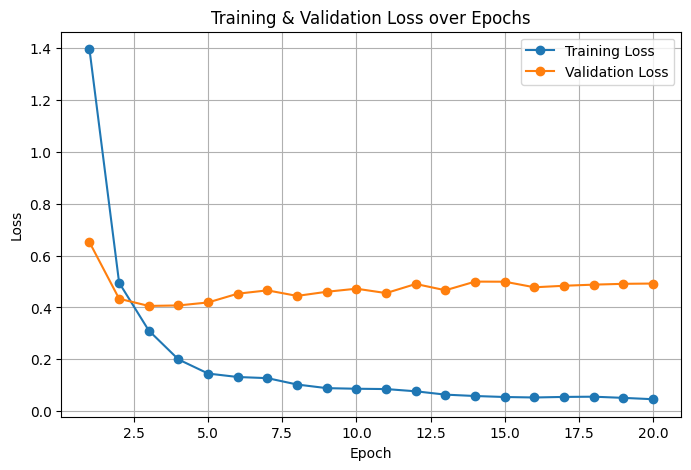

In [21]:

# --- Plot Loss Curves ---
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
